NOTE for instructor:
fits files, header, data, plot image, extract sources, wcs solution

# This notebook is intended to show how to plot an astronomical image and how to detect object in the image

let's start using the magic function we learned last time "%pylab inline"
<br> then we can import the packeages we will use today: sep, astropy  
<br> from astropy we will import: fits and wcs

In [1]:
%pylab inline
from astropy.io import fits
from astropy import wcs as wcs
import matplotlib.pyplot as plt
import numpy as np
import sep

Populating the interactive namespace from numpy and matplotlib


# read an image
16335757.fits is our test image. we will use fits.open to open and put the image in a variable img
<br> let's see the image format. Fits mean "Flexible Image Transport System" 
<br> this is a specific format composed by a metadata part and a data part.
The metadata (header) include all the info about the image and the data part is usually a bidimensional array. A fits image can have multiple layers of metadata and data.
<br> For example:<br>
<br> header, data  (level[0])
<br> header, data  (level[1])
<br> header, data  (level[2])
<br> You can see how many layers your image has using the function len()

In [2]:
img = fits.open('16335757.fits')
len(img)

1

Since the size is one, let's take a look at the layer zero. Each fits file has several important informations in what is called the header of the file. In the header you can find information like: the exposure time, the telescope, the data of the observations, the size of the data, the observer and sometimes also the informations of the part of the sky we observed 

In [3]:
header = img[0].header
print(header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 1024 / length of data axis 1                          NAXIS2  =                 1024 / length of data axis 2                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H DATE-OBS= '2016-04-30T01:18:07' /YYYY-MM-DDThh:mm:ss observation start, UT      EXPTIME =   60.000000000000000 /Exposure time in seconds                        EXPOSURE=   60.000000000000000 /Exposure time in seconds                        SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   CCD-TEMP=  -20.170235250000001 /CCD temp

Now let see the data

In [4]:
X = img[0].data
print(X)

[[227.64964 242.42308 254.67735 ... 260.97653 234.49554 257.19666]
 [222.01602 265.02048 248.61688 ... 249.39539 249.02998 263.34747]
 [242.40106 235.84102 219.14624 ... 260.77954 227.6311  245.4189 ]
 ...
 [258.41376 235.47336 252.11043 ... 254.78888 252.02977 224.48628]
 [253.63196 250.44969 258.99002 ... 264.21622 246.82892 265.422  ]
 [243.02887 276.27774 218.37288 ... 207.54837 259.7037  248.36153]]


The data is an array, so we can actually use matplotlib to "imshow" the image

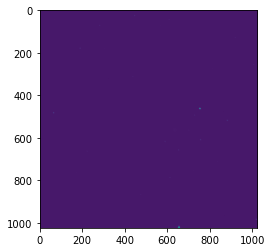

In [5]:
plt.imshow(X)

what is going on here? we do not see anything. Probably becasue there are some pixel in the array that have very low or very high counts.
So we can do an histogram and see the distribution of the points in the array 

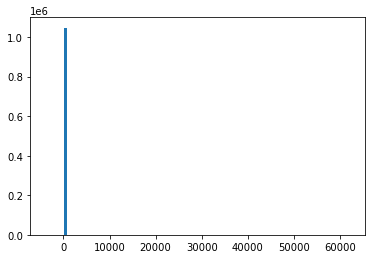

In [6]:
image_hist = plt.hist(X.flatten(), bins=100)

let do it again constraining the range of the histogram using range=(X,Y)

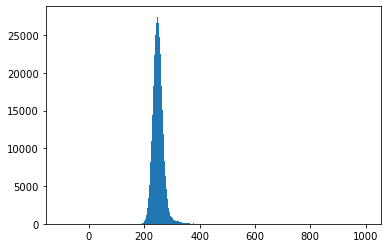

In [7]:
image_hist = plt.hist(X.flatten(), bins=1000,range=(-100,1000))

let's now do the plot again using some limits. what do yo think we should use?  vmin=-XX, vmax=YY)

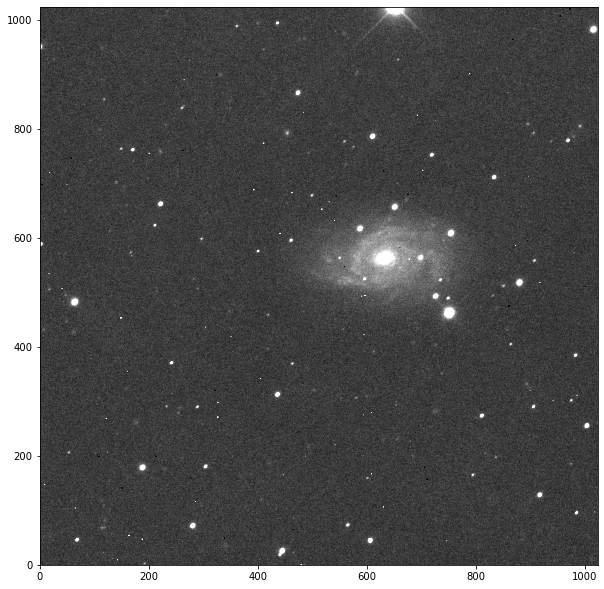

In [8]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(X, origin='lower', cmap='gray', vmin=200, vmax=400)

Now we would like to be able to find the position of all stars in the image. But in order to do that with the package sep, we need to define the background of the image. Sep has a command for that: sep.Background(X). 
But before doing that there is a command to run: X = X.byteswap().newbyteorder(

In [9]:
X = img[0].data
X = X.byteswap().newbyteorder() # magic command
bkg = sep.Background(X)

Now we can exstract all the objects from the image using the sep commmand sep.extract
and then we can plot all the star detected on our image.  thresh=3.0 define how many star we want to find larger numbers means we find less objects. This is similar to a dictionary with each column that can be identify by a name. 

In [10]:
objects = sep.extract(X, thresh=20.0, err=bkg.globalrms, mask=None, minarea=10, clean=True, clean_param=1.0, segmentation_map=False)
print(len(objects))
print(type(objects))
objects.dtype.names

52
<class 'numpy.ndarray'>


('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

# dictionary

objects is a NumPy structured array with many fields.

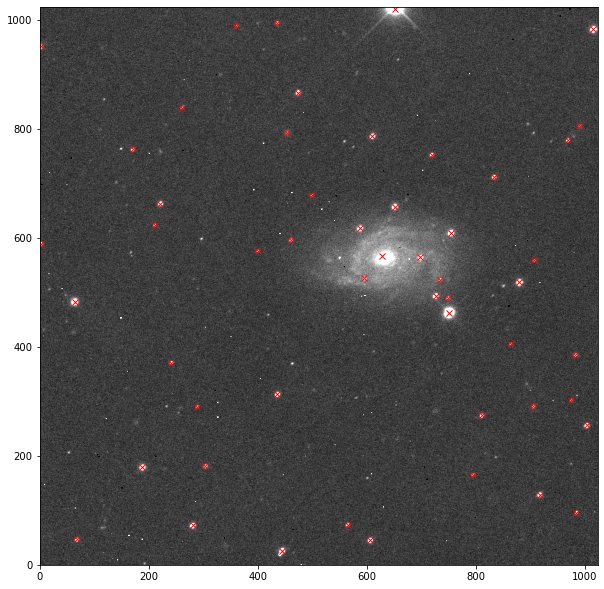

In [11]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(X, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(objects['x'],objects['y'],'xr')

if we know the coordinate of one interesting object, how we find it in the image?
To do that we can use the information on the header of the file and convert the coordinate in pixel position. To do that we will use the wcs package in astropy. 

In [12]:
#read the header
header = img[0].header
# import the wcs package
from astropy.wcs import WCS
# take information from the header about the coordinate where the image is pointing to.
w = WCS(header)
#transform coordinate in pixels:
Ra = 148.283666667
Dec = 16.7139583333
px, py = w.wcs_world2pix(Ra,Dec, 1)
print('my object should be close to these coordinate')
print(px,py)

my object should be close to these coordinate
611.6228472316652 786.023106657171


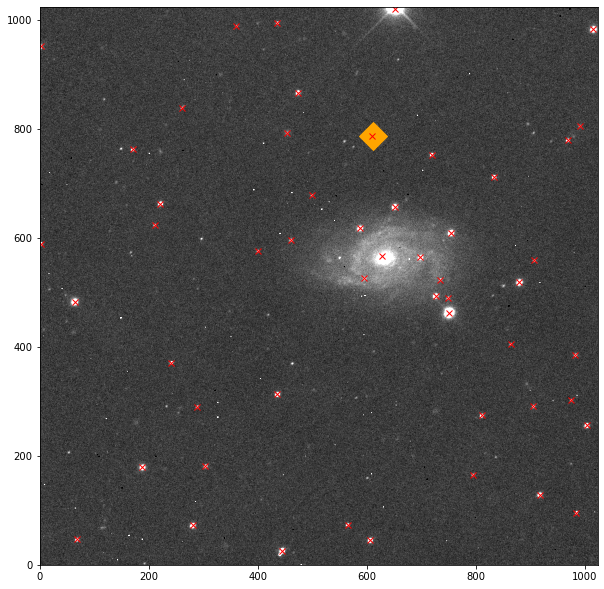

In [13]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(X, origin='lower', cmap='gray', vmin=200, vmax=400)
plt.plot(611,786,'D',color='orange',markersize=20)
plt.plot(objects['x'],objects['y'],'xr')

Now we want to identify in the object dictinary which is our object. We need to compare the pixel position for each object in the object dictionary with the pixel position we found. we need to measure the distance between them and take the object if the distance is less than XX pixels.
let's loop over the stars using enumerate and compute the difference between the coordinates
EXPLAIN enumerate, input to stop the loop line by line


In [14]:
#let's loop over the stars 
# we will use for and "enumerate"
# let's now make the difference between each pixel of an object and px py
for i,j in enumerate(objects['x']):
    print('distance ', (objects['x'][i]-px)**2+(objects['y'][i]-py)**2)
    if (objects['x'][i]-px)**2+(objects['y'][i]-py)**2 < 10:
       print('FOUND ',(objects['x'][i]-px)**2+(objects['y'][i]-py)**2,i,j)
       break
       print(i,j)
    input('')
    

distance  606218.811814135

distance  843527.8481868962

distance  549834.8819494349

distance  510388.84200081707

distance  620140.2866683039

distance  615860.7154908418

distance  525591.4491374915

distance  419055.846142043

distance  548470.5757165931

distance  461407.9747808731

distance  434973.82292945846

distance  302085.12784636

distance  350479.13981862355

distance  332034.50344298105

distance  366267.0371471671

distance  255099.38350877556

distance  309756.5272692411

distance  298688.838501308

distance  208617.4286756874

distance  124236.45702733232

distance  392790.9913583734

distance  106715.85927504052

distance  98876.73915315307

distance  143678.9370955655

distance  84317.87242682924

distance  68341.40762653315

distance  139082.9165115908

distance  56903.6944890372

distance  89034.62309039972

distance  410759.44156613335

distance  59178.64828294334

distance  48926.6882299012

distance  51684.124598782306

distance  29147.921814350702

distance  1